In [1]:

!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/snmahsa/soil-nutrients")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: makhmudkholmuminov
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/snmahsa/soil-nutrients


100%|██████████| 1.27M/1.27M [00:00<00:00, 473MB/s]

In [2]:
%mv "/content/soil-nutrients/Soil Nutrients.csv" "/content/soil-nutrients/soil_nutrients.csv"

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# ============================
# 1. LOAD DATA
# ============================
df = pd.read_csv("/content/soil-nutrients/soil_nutrients.csv")

# Drop ID column
df = df.drop(columns=["Name"])

X_all = df.drop(columns=["Yield"])
y = df["Yield"]

# Base categorical list (only these can be categorical)
base_categorical_cols = ["Fertility", "Photoperiod", "Category_pH", "Soil_Type", "Season"]

# Train-test split ONCE so it is the same for both feature sets
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

# ============================
# 2. DEFINE MODELS
# ============================
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
    ),
    "SVR": SVR(
        kernel="rbf",
        C=10.0,
        epsilon=0.1,
        gamma="scale"
    ),
}

# ============================
# 3. DEFINE TWO FEATURE SETS
# ============================
all_features = X_all.columns.tolist()

core_feats = ["Temperature", "Rainfall", "N_Ratio", "P_Ratio", "K_Ratio"]

feature_sets = {
    "Full": all_features,
    "Temp_Rain_Ratios": core_feats,
}

# ============================
# 4. TRAIN + EVALUATE
# ============================
results = []
trained_models = {}

feature_sets = {
    "Full": all_features,                # all columns except Name and Yield
    "Temp_Rain_Ratios": core_feats,      # ["Temperature", "Rainfall", "N_Ratio", "P_Ratio", "K_Ratio"]
}

for fs_name, fs_cols in feature_sets.items():
    print(f"\n=== Feature set: {fs_name} ===")

    X_train = X_train_full[fs_cols]
    X_test = X_test_full[fs_cols]

    categorical_cols = [c for c in base_categorical_cols if c in fs_cols]
    numeric_cols = [c for c in fs_cols if c not in categorical_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )

    for model_name, model in models.items():
        pipe = Pipeline(steps=[
            ("preprocess", preprocess),
            ("model", model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append({
            "Feature_Set": fs_name,
            "Model": model_name,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
        })

        trained_models[(fs_name, model_name)] = pipe      # <- now consistent
  # store for later use (SHAP, plots, etc.)

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\n=== Results ===")
print(results_df)

# Optional: sort nicely
print("\nSorted by RMSE:")
print(results_df.sort_values(["Feature_Set", "RMSE"]))



=== Feature set: Full ===

=== Feature set: Temp_Rain_Ratios ===

=== Results ===
        Feature_Set         Model        RMSE       MAE        R2
0              Full        Linear   32.967105  4.432681  0.868900
1              Full         Ridge   32.968201  4.432355  0.868895
2              Full  RandomForest    1.618002  0.672349  0.993566
3              Full       XGBoost    1.733311  0.734615  0.993107
4              Full           SVR    2.061888  0.874944  0.991800
5  Temp_Rain_Ratios        Linear  102.285388  7.003618  0.593242
6  Temp_Rain_Ratios         Ridge  102.285226  7.003780  0.593243
7  Temp_Rain_Ratios  RandomForest   31.457511  3.425822  0.874903
8  Temp_Rain_Ratios       XGBoost   28.320571  3.386563  0.887378
9  Temp_Rain_Ratios           SVR   40.180774  4.162279  0.840213

Sorted by RMSE:
        Feature_Set         Model        RMSE       MAE        R2
2              Full  RandomForest    1.618002  0.672349  0.993566
3              Full       XGBoost    1.733

In [5]:
# ----- FULL feature set -----
full_results = results_df[results_df["Feature_Set"] == "Full"]
best_full_row = full_results.sort_values("RMSE").iloc[0]
best_full_model_name = best_full_row["Model"]
print("Best FULL model:", best_full_model_name, best_full_row[["RMSE", "R2"]])

best_full_pipe = trained_models[("Temp_Rain_Ratios", best_full_model_name)]
X_test_full_fs = X_test_full[feature_sets["Full"]]   # all full features
y_pred_full = best_full_pipe.predict(X_test_full_fs)

# ----- REDUCED feature set -----
reduced_name = "Temp_Rain_Ratios"
reduced_results = results_df[results_df["Feature_Set"] == reduced_name]
best_red_row = reduced_results.sort_values("RMSE").iloc[0]
best_red_model_name = best_red_row["Model"]
print("Best REDUCED model:", best_red_model_name, best_red_row[["RMSE", "R2"]])

best_red_pipe = trained_models[(reduced_name, best_red_model_name)]
X_test_red_fs = X_test_full[feature_sets[reduced_name]]
y_pred_red = best_red_pipe.predict(X_test_red_fs)


Best FULL model: RandomForest RMSE    1.618002
R2      0.993566
Name: 2, dtype: object
Best REDUCED model: XGBoost RMSE    28.320571
R2       0.887378
Name: 8, dtype: object


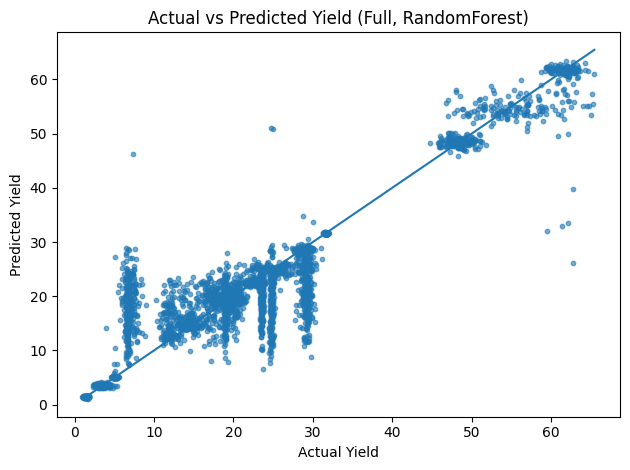

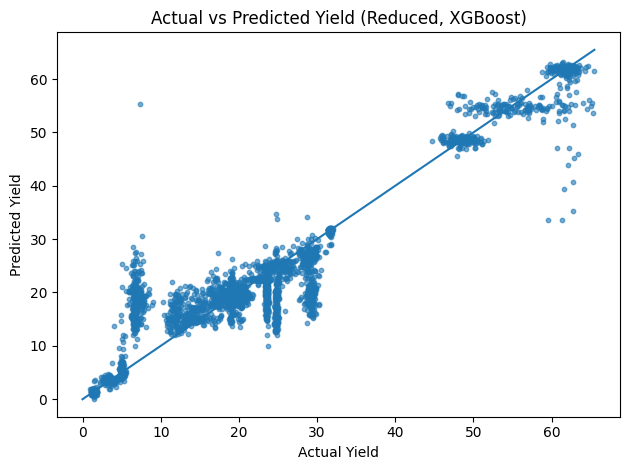

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Full
plt.figure()
plt.scatter(y_test, y_pred_full, s=10, alpha=0.6)
mn = min(y_test.min(), y_pred_full.min())
mx = max(y_test.max(), y_pred_full.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title(f"Actual vs Predicted Yield (Full, {best_full_model_name})")
plt.tight_layout()
plt.savefig("actual_vs_pred_full.png", dpi=300)

# Reduced
plt.figure()
plt.scatter(y_test, y_pred_red, s=10, alpha=0.6)
mn = min(y_test.min(), y_pred_red.min())
mx = max(y_test.max(), y_pred_red.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title(f"Actual vs Predicted Yield (Reduced, {best_red_model_name})")
plt.tight_layout()
plt.savefig("actual_vs_pred_reduced.png", dpi=300)


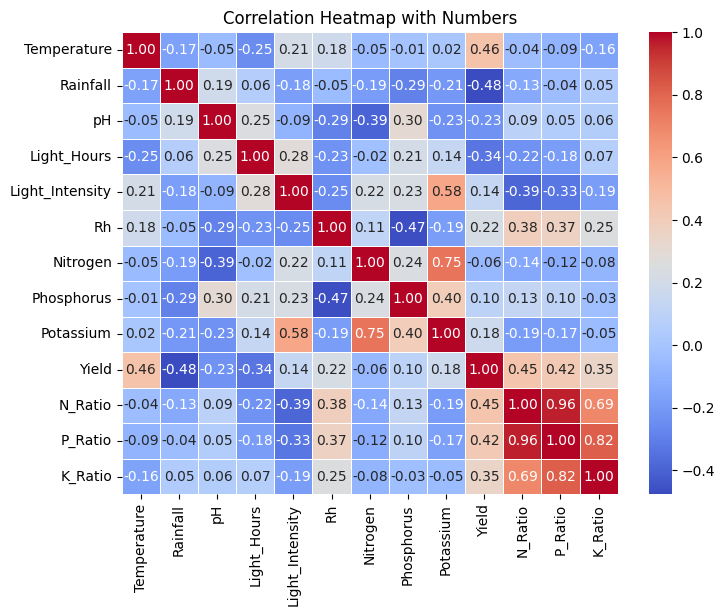

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Set up the figure size
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(
    corr,
    annot=True,       # Add the numbers to the cells
    cmap='coolwarm',  # Use a diverging color palette
    fmt=".2f",        # Format the numbers to two decimal places
    linewidths=0.5    # Add lines between cells
)

# Add a title
plt.title("Correlation Heatmap with Numbers")

plt.savefig('correlation_matrix.png')
# Display the plot
plt.show()


Starting SHAP comparison analysis...

📊 Preparing FULL feature set...
   Features: 27

📊 Preparing CORE feature set (5 features)...
   Features: Temperature, Rainfall, N_Ratio, P_Ratio, K_Ratio

🔧 Training XGBoost with FULL features...
   ✓ R² score: 0.9927

🔧 Training XGBoost with CORE features...
   ✓ R² score: 0.8903

📈 Calculating SHAP values for FULL features...
   ✓ Done

📈 Calculating SHAP values for CORE features...
   ✓ Done

🎨 Creating beautiful comparison plot...

✅ Comparison plot saved as 'shap.png'


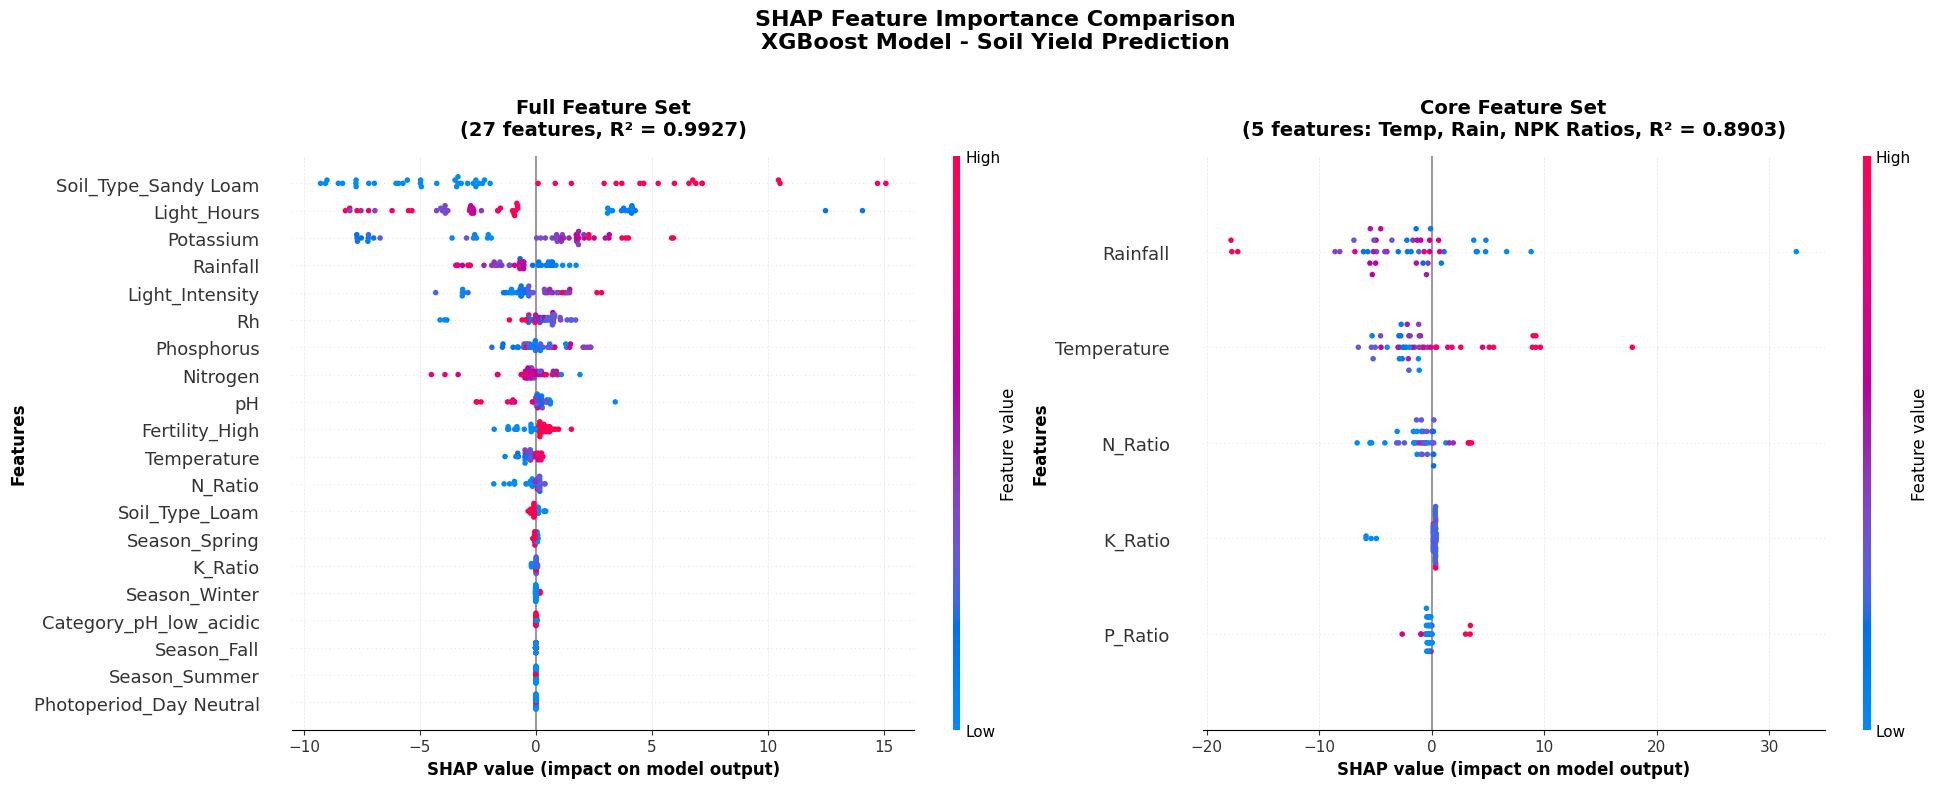


MODEL PERFORMANCE COMPARISON
  Feature Set  Number of Features  R² Score  Performance Gap
Full Features                  27   0.99268          0.00000
Core Features                   5   0.89026          0.10242

TOP 15 FEATURES (FULL MODEL)
             Feature  Mean |SHAP|
Soil_Type_Sandy Loam     5.581334
         Light_Hours     4.136305
           Potassium     3.094494
            Rainfall     1.239897
     Light_Intensity     1.160693
                  Rh     0.749824
          Phosphorus     0.717209
            Nitrogen     0.657321
                  pH     0.498958
      Fertility_High     0.490988
         Temperature     0.327447
             N_Ratio     0.277544
      Soil_Type_Loam     0.124246
       Season_Spring     0.052851
             K_Ratio     0.030212

CORE FEATURES RANKING
    Feature  Mean |SHAP|
   Rainfall     4.897615
Temperature     3.541726
    N_Ratio     1.623015
    K_Ratio     0.697583
    P_Ratio     0.506349

KEY INSIGHTS

Core features ranking in 

In [8]:
# ============================
# SHAP COMPARISON: FULL vs CORE FEATURES
# Two beeswarm plots side by side
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

print("Starting SHAP comparison analysis...")

# ============================
# 1. LOAD DATA
# ============================
df = pd.read_csv("/content/soil-nutrients/soil_nutrients.csv")
df = df.drop(columns=["Name"])

X = df.drop(columns=["Yield"])
y = df["Yield"]

# ============================
# 2. DEFINE TWO FEATURE SETS
# ============================

# FULL FEATURE SET
print("\n📊 Preparing FULL feature set...")
X_full = pd.get_dummies(X, drop_first=False)
print(f"   Features: {X_full.shape[1]}")

# CORE FEATURE SET (5 features only)
print("\n📊 Preparing CORE feature set (5 features)...")
core_features = ["Temperature", "Rainfall", "N_Ratio", "P_Ratio", "K_Ratio"]
X_core = X[core_features]
print(f"   Features: {', '.join(core_features)}")

# Split both datasets
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

X_train_core, X_test_core, _, _ = train_test_split(
    X_core, y, test_size=0.2, random_state=42
)

# ============================
# 3. TRAIN MODEL 1: FULL FEATURES
# ============================
print("\n🔧 Training XGBoost with FULL features...")

model_full = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_full.fit(X_train_full, y_train)
r2_full = model_full.score(X_test_full, y_test)
print(f"   ✓ R² score: {r2_full:.4f}")

# ============================
# 4. TRAIN MODEL 2: CORE FEATURES
# ============================
print("\n🔧 Training XGBoost with CORE features...")

model_core = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_core.fit(X_train_core, y_train)
r2_core = model_core.score(X_test_core, y_test)
print(f"   ✓ R² score: {r2_core:.4f}")

# ============================
# 5. CALCULATE SHAP VALUES (FULL)
# ============================
print("\n📈 Calculating SHAP values for FULL features...")

X_test_sample_full = X_test_full.head(50)
explainer_full = shap.TreeExplainer(model_full)
shap_values_full = explainer_full.shap_values(X_test_sample_full)
print("   ✓ Done")

# ============================
# 6. CALCULATE SHAP VALUES (CORE)
# ============================
print("\n📈 Calculating SHAP values for CORE features...")

X_test_sample_core = X_test_core.head(50)
explainer_core = shap.TreeExplainer(model_core)
shap_values_core = explainer_core.shap_values(X_test_sample_core)
print("   ✓ Done")

# ============================
# 7. CREATE SIDE-BY-SIDE COMPARISON
# ============================
print("\n🎨 Creating beautiful comparison plot...")

# Set style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ============================
# LEFT PLOT: FULL FEATURES
# ============================
plt.sca(axes[0])
shap.summary_plot(
    shap_values_full,
    X_test_sample_full,
    plot_type="dot",
    max_display=20,
    show=False,
    plot_size=None
)

axes[0].set_title(
    f"Full Feature Set\n({X_full.shape[1]} features, R² = {r2_full:.4f})",
    fontsize=14,
    fontweight='bold',
    pad=15
)
axes[0].set_xlabel("SHAP value (impact on model output)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Features", fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
axes[0].set_axisbelow(True)

# ============================
# RIGHT PLOT: CORE FEATURES
# ============================
plt.sca(axes[1])
shap.summary_plot(
    shap_values_core,
    X_test_sample_core,
    plot_type="dot",
    max_display=5,  # Only 5 features
    show=False,
    plot_size=None
)

axes[1].set_title(
    f"Core Feature Set\n(5 features: Temp, Rain, NPK Ratios, R² = {r2_core:.4f})",
    fontsize=14,
    fontweight='bold',
    pad=15
)
axes[1].set_xlabel("SHAP value (impact on model output)", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Features", fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
axes[1].set_axisbelow(True)

# Add main title
fig.suptitle(
    "SHAP Feature Importance Comparison\nXGBoost Model - Soil Yield Prediction",
    fontsize=16,
    fontweight='bold',
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save high-quality figure
plt.savefig("shap.png", dpi=300, bbox_inches='tight', facecolor='white')
print("\n✅ Comparison plot saved as 'shap.png'")

plt.show()
plt.close()

# ============================
# 8. PRINT COMPARISON STATISTICS
# ============================
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Feature Set': ['Full Features', 'Core Features'],
    'Number of Features': [X_full.shape[1], 5],
    'R² Score': [r2_full, r2_core],
    'Performance Gap': [0, r2_full - r2_core]
})

print(comparison.to_string(index=False))

# ============================
# 9. TOP FEATURES FROM FULL MODEL
# ============================
print("\n" + "="*80)
print("TOP 15 FEATURES (FULL MODEL)")
print("="*80)

mean_abs_shap_full = np.abs(shap_values_full).mean(axis=0)
feature_importance_full = pd.DataFrame({
    'Feature': X_test_sample_full.columns,
    'Mean |SHAP|': mean_abs_shap_full
}).sort_values('Mean |SHAP|', ascending=False)

print(feature_importance_full.head(15).to_string(index=False))

# ============================
# 10. CORE FEATURES RANKING
# ============================
print("\n" + "="*80)
print("CORE FEATURES RANKING")
print("="*80)

mean_abs_shap_core = np.abs(shap_values_core).mean(axis=0)
feature_importance_core = pd.DataFrame({
    'Feature': X_test_sample_core.columns,
    'Mean |SHAP|': mean_abs_shap_core
}).sort_values('Mean |SHAP|', ascending=False)

print(feature_importance_core.to_string(index=False))

# ============================
# 11. INSIGHTS
# ============================
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Check if core features are in top features of full model
core_in_top_full = []
for feat in core_features:
    rank = feature_importance_full[feature_importance_full['Feature'] == feat].index
    if len(rank) > 0:
        core_in_top_full.append(f"  • {feat}: Rank #{rank[0] + 1} in full model")

print("\nCore features ranking in full model:")
for item in core_in_top_full:
    print(item)

performance_diff = r2_full - r2_core
print(f"\n📊 Performance difference: {performance_diff:.4f}")
if performance_diff < 0.02:
    print("   → Core features capture most predictive power!")
elif performance_diff < 0.05:
    print("   → Core features are quite effective, but full features help.")
else:
    print("   → Full feature set provides significant improvement.")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print("\nInterpretation Guide:")
print("• Red dots = high feature values")
print("• Blue dots = low feature values")
print("• Right (positive SHAP) = increases yield prediction")
print("• Left (negative SHAP) = decreases yield prediction")
print("• Features at top = more important for predictions")